# FMR standard problem

In [1]:
L = 120e-9  # x and y dimensions of the sample(m)
thickness = 10e-9  # sample thickness (m)
dx = dy = dz = 5e-9  # discretisation in x, y, and z directions (m)

# Minimum sample coordinate.
cmin = (0, 0, 0)
# Maximum sample coordinate.
cmax = (L, L, thickness)
# Discretisation.
d = (dx, dy, dz)

In [2]:
import numpy as np

Ms = 8e5  # saturation magnetisation (A/m)
A = 1.3e-11  # exchange energy constant (J/m)
H = 8e4 * np.array([0.81345856316858023, 0.58162287266553481, 0.0])

In [3]:
import sys

sys.path.append('../')

from sim import Sim
from energies.exchange import UniformExchange
from energies.demag import Demag
from energies.zeeman import FixedZeeman

In [4]:
sim = Sim(cmin, cmax, d, Ms, name='relaxation_stage')

In [5]:
# Add exchange energy.
sim.add(UniformExchange(A))
# Add demagnetisation energy.
sim.add(Demag())
# Add Zeeman energy.
sim.add(FixedZeeman(H))

In [6]:
def m_init(pos):
    return (1, 1, 0)

sim.set_m(m_init)

In [7]:
sim.run_until(5e-9)

In [8]:
!ls

fmr_standard_problem.ipynb  relaxation_stage.mif
m0file.omf		    relaxation_stage-Oxs_TimeDriver-Spin-00-0004155.omf


In [9]:
from field import Field, load_oommf_file

m0 = load_oommf_file('relaxation_stage-Oxs_TimeDriver-Spin-00-0004155.omf')

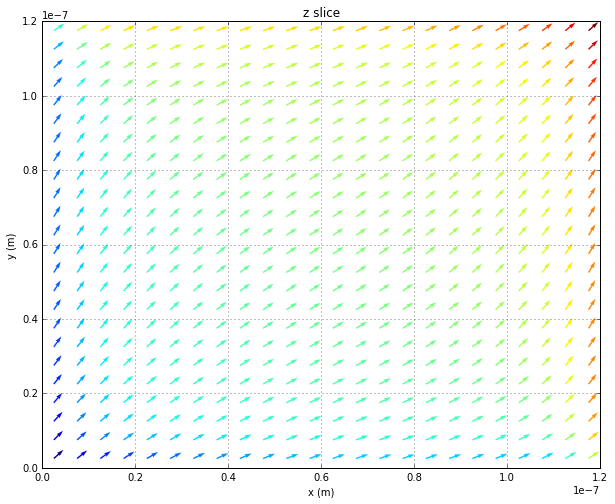

In [10]:
%matplotlib inline
m0.plot_slice('z', 5e-9)

## Dynamic stage

In [11]:
sim = Sim(cmin, cmax, d, Ms, name='dynamic_stage')

# Add exchange energy.
sim.add(UniformExchange(A))
# Add demagnetisation energy.
sim.add(Demag())

In [12]:
# Add Zeeman energy.
H = 8e4 * np.array([0.81923192051904048, 0.57346234436332832, 0.0])
sim.add(FixedZeeman(H))

In [13]:
sim.set_m(m0)

In [14]:
sim.alpha = 0.008

In [15]:
dt = 5e-12
n_steps = 4000

sim.run_multiple_stages(dt, n_steps)

## Postprocessing

In [17]:
import glob

t_list = []
myav = []
for i in xrange(n_steps):
    omf_filename = glob.glob('dynamic_stage-Oxs_TimeDriver-Spin-%09d-*.omf' % i)[0]
    m_field = load_oommf_file(omf_filename)
    t_list.append(i*dt)
    myav.append(m_field.average()[1])
    
t_array = np.array(t_list)
myav = np.array(myav)

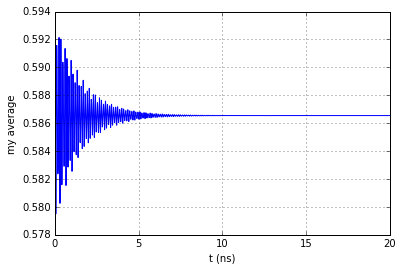

In [19]:
import matplotlib.pyplot as plt

plt.plot(t_array/1e-9, myav)
plt.xlabel('t (ns)')
plt.ylabel('my average')
plt.grid()

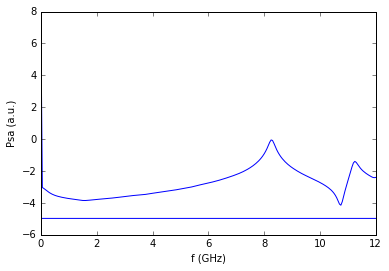

In [26]:
import scipy.fftpack

psd = np.log10(np.abs(scipy.fftpack.fft(myav))**2)
f_axis = scipy.fftpack.fftfreq(n_steps, d=dt)

plt.plot(f_axis/1e9, psd)
plt.xlim([0, 12])
plt.xlabel('f (GHz)')
plt.ylabel('Psa (a.u.)')